NOTES FOR THIS VERSION:

In addition to the basic function 'aprop', created a new version 'aprop_vec' that incorporates a little bit of vectorized code.

Vectorized parts of code are marked with '### BEGIN: code edited for vectorization'.

Run times for 'aprop' and 'aprop_vec' are compared at the end. Although these changes to the code are not very dramatic, there is a significant decrease in runtime. 

Noticed that when num_stable_iters is small, like 3, the vectorized version for some reason converges to an obviously incorrect-looking clustering (stabilizes too soon). So changed the default num_stable_iters to 10; seemed to solve the problem. (Also, I saw a couple of test cases where the vectorized code seemed to result in a visually "better" clustering than the non-vectorized version and/or did it in fewer iterations, which is quite interesting... I guess I assumed the number of iterations would be the same for the vectorized version, but they'd be faster!)

Adding number of stopping iteration as returned object.

In [86]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sklearn.cluster as skc

In [87]:
# simulated data to use for clustering

C1 = np.random.multivariate_normal(mean=[0,0], cov=np.eye(2), size=30)
C2 = np.random.multivariate_normal(mean=[4,4], cov=np.eye(2), size=30)
mydata = np.r_[C1, C2]

In [88]:
# function definition - not vectorized

def aprop(mydata, num_cluster_pref=1, iterations=100, damp_c=0.5, num_stable_iters=10):
    
    """
    Perform clustering by affinity propagation. 
    
    
    Parameters
    ----------
    
    mydata : array-like, shape (num_data_pts, 2)
        Data set for clustering.
        
    num_cluster_pref : int (1 or 2), optional, default: 1
        Indication of whether the input similarities are set to the minimum similarity measure 
        (IE, negative squared Euclidean distance) between the data points (num_cluster_pref = 1), 
        or the median similarity measure (num_cluster_pref = 2).
        
    iterations : int, optional, default: 100
        Maximum number of iterations to run affinity propagation.
    
    damp_c : float, optional, default: 0.5
        Damping constant. The weight given to the updating iteration; between 0 and 1.
        
    num_stable_iters : int, optional, default: 10
        The algorithm stops if the clusterings at each iteration have remained unchanged for 
        this many iterations in a row.
        
       
    Returns
    -------
    
    clusters : array, shape (num_data_pts, 1)
        For the index of each data point, gives that data point's exemplar.
    
    exemplars : array, shape(num_exemplars, 1)
        List the indices of the data points that are exemplars.
    
    cluster_plot : figure
        Scatter plot of the data, with points in the same cluster hacing the same color, and
        exemplars marked with plus-signs.
        
    num_clusters : int
        Number of clusters in final clustering.
        
    final_iter : int
        Number of iterations that were run before the algorithm stopped.
        
        
    Notes
    -----
    
    Input preferences should be set to the minimum similarity measure when a small number of clusters
    is preferred, and to the median similarity measure when a moderate number of clusters is 
    preferred.
    
    If stability is not acheived, the aglorithm does not output the returned objects but 
    rather prints an error message: "Stability not acheived. Consider reducing num_stable_iters."
    
    
    References
    ----------
    
    Brendan J. Frey and Delbert Dueck, "Clustering by Passing Messages
    Between Data Points", Science Feb. 2007
    
    """
    # data input error messages
    if mydata.shape[1] != 2:
        raise ValueError("S must have two columns.")
    if num_cluster_pref != 1 and num_cluster_pref != 2:
        raise ValueError("Enter valid indication (1 or 2) of cluster number preference.")
    if iterations <1 or type(iterations) != int:
        raise ValueError("Enter a valid number of iterations.")
    if damp_c <= 0 or damp_c > 1:
        raise ValueError("Enter a valid damping constant.")
    if num_stable_iters < 1 or num_stable_iters > iterations or type(num_stable_iters) != int:
        raise ValueError("Enter a valid number of iterations to check for stability.")
    
    # count number of data points, IE number rows in mydata
    num_data_pts = mydata.shape[0]
    
    ### create similarity matrix for data

    # negative square euclidean distance used as similarity measure
    def s_metric(i,k, mydata):
        return -np.linalg.norm(mydata[i] - mydata[k])**2

    # initialize a matrix of s_metric distances between all points in mydata
    s_metric_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts))

    # compute the negative square euclidean distances btw all pts and record in s_metric_matrix
    for i in range(num_data_pts):
        for k in range(num_data_pts):
            s_metric_matrix[i,k] = s_metric(i, k, mydata)

    # find the minimum similarity measure
    s_metric_min_dist = np.matrix(s_metric_matrix).min()
    s_metric_med_dist = np.median(s_metric_matrix)

    # define similarity function s, where each point k is assigned
    # a similarity measure s(k,k) equal to the minimum of all the 
    # similarity measures
    def s(i, k, mydata):
        if i==k and num_cluster_pref==1: # if point indices are equal are  equal
            return s_metric_min_dist 
        elif i==k:
            return s_metric_med_dist
        # assign the minimum s-distance in the matrix
        else: # if x and y are not equal
            return s_metric(i, k, mydata) # assign usual s-distance measure

    # create s_matrix, which records s(i,k) for all point indices i and k
    s_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts))

    for i in range(num_data_pts):
        for k in range(num_data_pts):
            s_matrix[i,k] = s(i, k, mydata)
            
    # a(i,k) = 0 at first iteration
    a_array = np.zeros(num_data_pts * num_data_pts * (iterations)).reshape((iterations, num_data_pts, num_data_pts))

    # initialize r_array 
    r_array = np.zeros(num_data_pts * num_data_pts * (iterations)).reshape((iterations, num_data_pts, num_data_pts))

    # fill in r_array values for 0th iteration 
    ## edit
    max_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts)) # initialize
    for i in range(num_data_pts): # for each row i
        for k in range(num_data_pts): # for each col k
            # mask the (i,k)th element in similarity matrix
            s_matrix_mask = np.ma.array(s_matrix, mask=False)
            s_matrix_mask.mask[i,k] = True # mask item (i,k)
            max_matrix[i,k] = np.max(s_matrix_mask[i,:]) # get max in row i, but without item (i,k)

    r_array[0] = s_matrix - max_matrix
    
    ### iterative loop for iterations 1+ 

    clusters_prev = np.zeros(num_data_pts)
    clusters_prev_2 = np.zeros(num_data_pts)
    iter_stability = np.zeros(iterations)

    for niter in range(1,iterations):

        for i in range(num_data_pts):
            for k in range(num_data_pts):
                    # if elements are negative mask them 
                    ## edit
                    if i != k:
                        r_array_mask = np.ma.array(r_array[niter-1], mask=False) # copy previous iteration of r_array, as mask
                        r_array_mask.mask[k,k] = True # mask r(niter-1, k, k)
                        r_array_mask.mask[i,k] = True # mask r(niter-1, i, k)
                        r_array_mask.mask[r_array_mask<0] = True # mask any negative elements in r(niter-1)
                        a_ik_sum = np.sum(r_array_mask[:,k]) # compute summation
                        for_min = np.concatenate((r_array[niter-1,k,k] + a_ik_sum, np.zeros(1)), axis=None)
                        update_term = np.min(for_min)
                        a_array[niter,i,k] = damp_c * update_term + (1-damp_c) * a_array[niter-1,i,k]
                    else:
                        r_array_mask = np.ma.array(r_array[niter-1], mask=False) # copy previous iteration of r_array, as mask
                        r_array_mask.mask[k,k] = True # mask r(niter-1, k, k)
                        r_array_mask.mask[r_array_mask<0] = True # mask any negative elements in r(niter-1)
                        a_ik_sum = np.sum(r_array_mask[:,k]) # compute summation
                        if np.ma.is_masked(a_ik_sum):
                            update_term = 0
                        else:
                            update_term = a_ik_sum
                        a_array[niter,i,k] = damp_c * update_term + (1-damp_c) * a_array[niter-1,i,k]
        # r update
        for i in range(num_data_pts):
            for k in range(num_data_pts):
                s_a_array_sum = a_array[niter] + s_matrix
                s_a_array_sum_mask = np.ma.array(s_a_array_sum, mask=False)
                s_a_array_sum_mask.mask[:,k] = True
                #print(s_a_array_sum_mask)
                s_a_array_sum_max = np.max(s_a_array_sum_mask[i,:])
                #print(s_a_array_sum_max)
                update_term = s_matrix[i,k] - s_a_array_sum_max
                #print(update_term)
                r_array[niter,i,k] = damp_c * update_term + (1-damp_c) * r_array[niter-1,i,k]
        r_s_sum_array = r_array[niter] + a_array[niter]

        # print illustration of first clustering that remains stable over two iterations
        # centers marked by black plus signs
        # points assigned to same center have same color
        if niter > 0: 
            clusters = np.argmax(r_s_sum_array, axis=1) # the list points grouped by their assigned center
            centers = np.where(np.argmax(r_s_sum_array, axis=1) == np.array(range(num_data_pts))) # the points that are centers
            is_center = np.argmax(r_s_sum_array, axis=1) == np.array(range(num_data_pts)) # true if pt is a center, false otherwise
            if np.array_equal(clusters, clusters_prev): # if the clustering in this iteration is the same as the previous one
                iter_stability[niter] = 1 
            if niter>num_stable_iters and np.all(iter_stability[niter-num_stable_iters:niter]==1): # if you have seen enough of the same clusterings in a row
                plt.scatter(mydata[:,0], mydata[:,1], c=np.argmax(r_s_sum_array, axis=1), s = 200)
                plt.scatter(mydata[:,0][is_center], mydata[:,1][is_center], marker='+', s=350, c='black')
                cluster_plot = plt.show()
                exemplars=centers[0]
                num_clusters = len(np.unique(clusters))
                final_iter = niter+1
                return clusters, exemplars, cluster_plot, num_clusters, final_iter
                break 
            elif niter == iterations-1:
                print("Stability not acheived. Consider reducing num_stable_iters.")
            clusters_prev = clusters


In [89]:
# function definition - vectorized

def aprop_vec(mydata, num_cluster_pref=1, iterations=100, damp_c=0.5, num_stable_iters=10):
    
    """
    Perform clustering by affinity propagation. 
    
    
    Parameters
    ----------
    
    mydata : array-like, shape (num_data_pts, 2)
        Data set for clustering.
        
    num_cluster_pref : int (1 or 2), optional, default: 1
        Indication of whether the input similarities are set to the minimum similarity measure 
        (IE, negative squared Euclidean distance) between the data points (num_cluster_pref = 1), 
        or the median similarity measure (num_cluster_pref = 2).
        
    iterations : int, optional, default: 100
        Maximum number of iterations to run affinity propagation.
    
    damp_c : float, optional, default: 0.5
        Damping constant. The weight given to the updating iteration; between 0 and 1.
        
    num_stable_iters : int, optional, default: 10
        The algorithm stops if the clusterings at each iteration have remained unchanged for 
        this many iterations in a row.
        
       
    Returns
    -------
    
    clusters : array, shape (num_data_pts, 1)
        For the index of each data point, gives that data point's exemplar.
    
    exemplars : array, shape(num_exemplars, 1)
        List the indices of the data points that are exemplars.
    
    cluster_plot : figure
        Scatter plot of the data, with points in the same cluster hacing the same color, and
        exemplars marked with plus-signs.
        
    num_clusters : int
        Number of clusters in final clustering.
        
    final_iter : int
        Number of iterations that were run before the algorithm stopped.
        
        
    Notes
    -----
    
    Input preferences should be set to the minimum similarity measure when a small number of clusters
    is preferred, and to the median similarity measure when a moderate number of clusters is 
    preferred.
    
    If stability is not acheived, the aglorithm does not output the returned objects but 
    rather prints an error message: "Stability not acheived. Consider reducing num_stable_iters."
    
    
    References
    ----------
    
    Brendan J. Frey and Delbert Dueck, "Clustering by Passing Messages
    Between Data Points", Science Feb. 2007
    
    """
    
    # data input error messages
    if mydata.shape[1] != 2:
        raise ValueError("S must have two columns.")
    if num_cluster_pref != 1 and num_cluster_pref != 2:
        raise ValueError("Enter valid indication (1 or 2) of cluster number preference.")
    if iterations <1 or type(iterations) != int:
        raise ValueError("Enter a valid number of iterations.")
    if damp_c <= 0 or damp_c > 1:
        raise ValueError("Enter a valid damping constant.")
    if num_stable_iters < 1 or num_stable_iters > iterations or type(num_stable_iters) != int:
        raise ValueError("Enter a valid number of iterations to check for stability.")
    
    # count number of data points, IE number rows in mydata
    num_data_pts = mydata.shape[0]
    
    ### create similarity matrix for data

    # negative square euclidean distance used as similarity measure
    def s_metric(i,k, mydata):
        return -np.linalg.norm(mydata[i] - mydata[k])**2

    # initialize a matrix of s_metric distances between all points in mydata
    s_metric_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts))

    # compute the negative square euclidean distances btw all pts and record in s_metric_matrix
    for i in range(num_data_pts):
        for k in range(num_data_pts):
            s_metric_matrix[i,k] = s_metric(i, k, mydata)

    # find the minimum similarity measure
    s_metric_min_dist = np.matrix(s_metric_matrix).min()
    s_metric_med_dist = np.median(s_metric_matrix)

    # define similarity function s, where each point k is assigned
    # a similarity measure s(k,k) equal to the minimum of all the 
    # similarity measures
    def s(i, k, mydata):
        if i==k and num_cluster_pref==1: # if point indices are equal are  equal
            return s_metric_min_dist 
        elif i==k:
            return s_metric_med_dist
        # assign the minimum s-distance in the matrix
        else: # if x and y are not equal
            return s_metric(i, k, mydata) # assign usual s-distance measure

    # create s_matrix, which records s(i,k) for all point indices i and k
    s_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts))

    for i in range(num_data_pts):
        for k in range(num_data_pts):
            s_matrix[i,k] = s(i, k, mydata)
            
    # a(i,k) = 0 at first iteration
    a_array = np.zeros(num_data_pts * num_data_pts * (iterations)).reshape((iterations, num_data_pts, num_data_pts))

    # initialize r_array 
    r_array = np.zeros(num_data_pts * num_data_pts * (iterations)).reshape((iterations, num_data_pts, num_data_pts))

    # fill in r_array values for 0th iteration 
    ## edit
    max_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts)) # initialize
    for i in range(num_data_pts): # for each row i
        for k in range(num_data_pts): # for each col k
            # mask the (i,k)th element in similarity matrix
            s_matrix_mask = np.ma.array(s_matrix, mask=False)
            s_matrix_mask.mask[i,k] = True # mask item (i,k)
            max_matrix[i,k] = np.max(s_matrix_mask[i,:]) # get max in row i, but without item (i,k)

    r_array[0] = s_matrix - max_matrix
    
    ### iterative loop for iterations 1+ 

    clusters_prev = np.zeros(num_data_pts)
    iter_stability = np.zeros(iterations)

    for niter in range(1,iterations):

        # a_array update
        for i in range(num_data_pts):
            for k in range(num_data_pts):
                    if i != k:
                        ### BEGIN: code edited for vectorization
                        # temp_vec is a vector of ones for each data point, except zeros for the ones that ashould be masked
                        temp_vec = np.ones(num_data_pts)
                        temp_vec[k] = 0
                        temp_vec[i] = 0
                        temp_vec[r_array[niter-1, :, k]<0] = 0
                        a_ik_sum = np.dot(r_array[niter-1, :, k], temp_vec) # do the summation using a dot product, instead of the masking process used previously for computing each individual entry
                        ### END: code edited for vectorization
                        for_min = np.concatenate((r_array[niter-1,k,k] + a_ik_sum, np.zeros(1)), axis=None)
                        update_term = np.min(for_min)
                        a_array[niter,i,k] = damp_c * update_term + (1-damp_c) * a_array[niter-1,i,k]
                    else:
                        ### BEGIN: code edited for vectorization
                        temp_vec = np.ones(num_data_pts)
                        temp_vec[k] = 0
                        temp_vec[r_array[niter-1, :, k]<0] = 0
                        a_ik_sum = np.dot(r_array[niter-1, :, k], temp_vec) # do the summation using a dot product, instead of the masking process used previously for computing each individual entry
                        ### END: code edited for vectorization
                        update_term = a_ik_sum
                        a_array[niter,i,k] = damp_c * update_term + (1-damp_c) * a_array[niter-1,i,k]
        # r_array update
        for i in range(num_data_pts):
            for k in range(num_data_pts):
                s_a_array_sum = a_array[niter] + s_matrix
                temp_vec = np.ones(num_data_pts)
                temp_vec[k] = 0
                s_a_array_sum_max = np.max(np.dot(s_a_array_sum[i,:], temp_vec))
                s_a_array_sum_mask = np.ma.array(s_a_array_sum, mask=False)
                s_a_array_sum_mask.mask[:,k] = True
                s_a_array_sum_max = np.max(s_a_array_sum_mask[i,:])
                update_term = s_matrix[i,k] - s_a_array_sum_max
                r_array[niter,i,k] = damp_c * update_term + (1-damp_c) * r_array[niter-1,i,k]
        r_s_sum_array = r_array[niter] + a_array[niter]

        # print illustration of first clustering that remains stable over two iterations
        # centers marked by black plus signs
        # points assigned to same center have same color
        if niter > 0: 
            clusters = np.argmax(r_s_sum_array, axis=1) # the list points grouped by their assigned center
            centers = np.where(np.argmax(r_s_sum_array, axis=1) == np.array(range(num_data_pts))) # the points that are centers
            is_center = np.argmax(r_s_sum_array, axis=1) == np.array(range(num_data_pts)) # true if pt is a center, false otherwise
            if np.array_equal(clusters, clusters_prev): # if the clustering in this iteration is the same as the previous one
                iter_stability[niter] = 1 
            if niter>num_stable_iters and np.all(iter_stability[niter-num_stable_iters:niter]==1): # if you have seen enough of the same clusterings in a row
                plt.scatter(mydata[:,0], mydata[:,1], c=np.argmax(r_s_sum_array, axis=1), s = 200)
                plt.scatter(mydata[:,0][is_center], mydata[:,1][is_center], marker='+', s=350, c='black')
                cluster_plot = plt.show()
                exemplars=centers[0]
                num_clusters = len(np.unique(clusters))
                final_iter = niter+1
                return clusters, exemplars, cluster_plot, num_clusters, final_iter
                break 
            elif niter == iterations-1:
                print("Stability not acheived. Consider reducing num_stable_iters.")
            clusters_prev = clusters



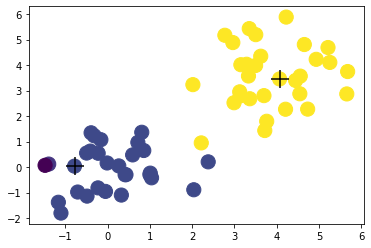

CPU times: user 50.8 s, sys: 252 ms, total: 51.1 s
Wall time: 50.7 s


(array([20, 20, 55, 20, 20, 20, 20, 20, 20, 20, 17, 20, 20, 20, 20, 20, 20,
        10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55, 55]), array([20, 55]), None, 4, 39)

In [90]:
%%time

# check time for non-vectorized code

aprop(mydata=mydata)

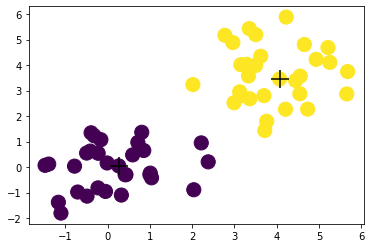

CPU times: user 23.8 s, sys: 304 ms, total: 24.1 s
Wall time: 23.7 s


(array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55, 55]), array([13, 55]), None, 2, 39)

In [91]:
%%time

# check time for vectorized code
aprop_vec(mydata=mydata)